In [36]:
import pandas as pd
from os import listdir, mkdir
from os.path import isfile, join, exists
from sklearn.model_selection import train_test_split
import numpy as np
import re

In [37]:
RANDOM_SEED = 500
hunglish_path = '../data/ftp.mokk.bme.hu/Hunglish2'

In [38]:
class HunglishSampler:
    def __init__(self, base_data_dir, sample_from_domains, seed, samples_per_domain_in_valid, samples_per_domain_in_test):
        self.domains = [
            'classic.lit',
            'law',
            'modern.lit',
            'softwaredocs',
            'subtitles'
        ]
        self.base_data_dir = base_data_dir
        self.sample_from_domains = sample_from_domains
        self.RANDOM_SEED = seed
        
        self.samples_per_domain_in_valid = samples_per_domain_in_valid
        self.samples_per_domain_in_test = samples_per_domain_in_test

        
    def sample(self):
        domain_data = {}
        data = {
            'train': {
                'hun': [],
                'eng': [],
                'source_file': [],
                'domain': []
            },
            'valid': {
                'hun': [],
                'eng': [],
                'source_file': [],
                'domain': []
            },
            'test': {
                'hun': [],
                'eng': [],
                'source_file': [],
                'domain': []
            }
        }

        for domain in self.sample_from_domains:
            if domain not in self.domains:
                raise ValueError(f'Cannot sample from domain {domain}')
            domain_data[domain] = {'hun': [], 'eng': [], 'source_file': []}
                
            domain_path = f'{self.base_data_dir}/{domain}/bi'
            files = [f for f in listdir(f'{domain_path}') if isfile(join(f'{domain_path}', f))]
            for file in files:
                with open(f'{domain_path}/{file}', 'r', encoding='latin2') as f:
                    hun_sentences = []
                    eng_sentences = []
                    malformed_lines = {}
                    for line in f:
                        try:
                            hun_sentence, eng_sentence = line.rstrip('\n').split('\t')
                            hun_sentences.append(hun_sentence)
                            eng_sentences.append(eng_sentence)
                            if len(hun_sentences) != eng_sentences:
                                raise ValueError(f'Hun-eng sentence pair has bad formatting')
                        except:
                            if domain not in malformed_lines:
                                malformed_lines[domain] = []
                            malformed_lines[domain].append((f'line: {line}', f'file: {file}'))
 
                    domain_data[domain]['hun'].extend(hun_sentences)
                    domain_data[domain]['eng'].extend(eng_sentences)
                    domain_data[domain]['source_file'].extend([file for _ in range(len(hun_sentences))])
            
            train_idxs, test_idxs = train_test_split(np.arange(len(domain_data[domain]['hun'])),
                                                     test_size=self.samples_per_domain_in_test,
                                                     random_state=self.RANDOM_SEED)
            train_idxs, valid_idxs = train_test_split(train_idxs,
                                                      test_size=self.samples_per_domain_in_valid,
                                                      random_state=self.RANDOM_SEED)
            
            for feature in ('hun', 'eng', 'source_file'):
#                 Not memory efficient
#                 data['train'][feature].extend(np.array(domain_data[domain][feature])[train_idxs].tolist())
#                 data['valid'][feature].extend(np.array(domain_data[domain][feature])[valid_idxs].tolist())
#                 data['test'][feature].extend(np.array(domain_data[domain][feature])[test_idxs].tolist())
                    
                for idx in train_idxs:
                    data['train'][feature].append(domain_data[domain][feature][idx])
                for idx in valid_idxs:
                    data['valid'][feature].append(domain_data[domain][feature][idx])
                for idx in test_idxs:
                    data['test'][feature].append(domain_data[domain][feature][idx])
                
            data['train']['domain'].extend([domain] * train_idxs.shape[0])
            data['valid']['domain'].extend([domain] * valid_idxs.shape[0])
            data['test']['domain'].extend([domain] * test_idxs.shape[0])
      
        print('Train set length: {}'.format(len(data['train']['hun'])))
        print('Validation set length: {}'.format(len(data['valid']['hun'])))
        print('Test set length: {}'.format(len(data['test']['hun'])))
        print('--------TRAIN--------')
        print(data['train']['hun'][0:3])
        print(data['train']['eng'][0:3])
        print('--------VALID--------')
        print(data['valid']['hun'][0:3])
        print(data['valid']['eng'][0:3])
        print('--------TEST--------')
        print(data['test']['hun'][0:3])
        print(data['test']['eng'][0:3])

        # Dump splits to dataframes
        self.train_set = pd.DataFrame(data['train'])
        self.valid_set = pd.DataFrame(data['valid'])
        self.test_set = pd.DataFrame(data['test'])
        
    def save_splits_to_csv(self):
        self.train_set.to_csv('./train_set.csv')
        self.valid_set.to_csv('./validation_set.csv')
        self.test_set.to_csv('./test_set.csv')

In [39]:
sampler = HunglishSampler(
                base_data_dir=hunglish_path,
                sample_from_domains= [
                        'classic.lit',
                        'law',
                        'modern.lit',
                        'softwaredocs',
                        'subtitles'
                        ],
                samples_per_domain_in_valid=5000,
                samples_per_domain_in_test=5000,
                seed=RANDOM_SEED
                
)
sampler.sample()

Train set length: 4103369
Validation set length: 25000
Test set length: 25000
--------TRAIN--------
['- Igenis ön!', '- Köszönöm, fiam - recsegte Mordon.', 'Soha állatnak nem szabad megölnie egy másik állatot.']
['"Yes; you!', '"Good boy," growled Moody.', 'No animal must ever kill any other animal.']
--------VALID--------
['Tizenöt percig olvasott, ebből az első tíz percet azzal töltötte, hogy megpróbált rájönni, hogy az előző éjjel hol hagyta abba az olvasást, majd eloltotta a lámpát és néhány percen belül elaludt.', 'Csak eltűnődtem rajta, hogy milyen ravaszul és előrelátóan kiterveltem mindent, mégis hiba csúszhatott a számításaimba, és hogy milyen nagy árat fizettem ezért.', 'Mint tudja, még Londonban levágattam a hajam, s a levágott fonatot magammal hoztam az utazóládám alján.']
['He read for fifteen minutes, spending the first ten minutes of that trying to work out where in the book he had got to the previous night, then he turned out the light and within a minute or so more was

# Check splits

In [40]:
sampler.train_set

,hun,eng,source_file,domain
0,- Igenis ön!,"""Yes; you!",Shuffle,classic.lit
1,"- Köszönöm, fiam - recsegte Mordon.","""Good boy,"" growled Moody.",Shuffle,classic.lit
2,Soha állatnak nem szabad megölnie egy másik ál...,No animal must ever kill any other animal.,Shuffle,classic.lit
3,"Miután leszüretelték, egy sötét és poros fiókr...",Once picked it needs a dark dusty drawer in wh...,Shuffle,classic.lit
4,"Haragra gerjedek a bűnösök miatt, akik áthágjá...","A fainting hath taken hold of me, because of t...",Bible_2.bi,classic.lit
...,...,...,...,...
4103364,Találd meg Amanda-t!,Find Amanda!,subtitles.bi,subtitles
4103365,Ügyes.,That's good.,subtitles.bi,subtitles
4103366,Azt nézd meg.,CINDY: Look at this.,subtitles.bi,subtitles
4103367,"Visszatérne ujjaidba elfeledett erőd, ha régi ...",Your fingers would remember their old strength...,subtitles.bi,subtitles


In [41]:
sampler.valid_set

,hun,eng,source_file,domain
0,"Tizenöt percig olvasott, ebből az első tíz per...","He read for fifteen minutes, spending the firs...",Shuffle,classic.lit
1,"Csak eltűnődtem rajta, hogy milyen ravaszul és...",It is merely that I have been sitting here and...,Shuffle,classic.lit
2,"Mint tudja, még Londonban levágattam a hajam, ...","I had, as you know, cut off my hair in London,...",Shuffle,classic.lit
3,"Nevét nem törlöm ki az élet könyvéből, hanem m...",And I will confess his name before my Father a...,Bible_3.bi,classic.lit
4,"Ha lóra kap, végünk van.","If he mounts, we are gone.",Cooper_1.bi,classic.lit
...,...,...,...,...
24995,- Hathaway őrnagy vagyok.,I'm Major Hathaway.,subtitles.bi,subtitles
24996,"Nem tudhatjuk, ki figyel még.",We do not know who else may be watching.,subtitles.bi,subtitles
24997,"Te buszvezető vagy, Raoul.","You're a bus driver, Raoul.",subtitles.bi,subtitles
24998,Halottak vagyunk.,We're dead.,subtitles.bi,subtitles


In [42]:
sampler.test_set

,hun,eng,source_file,domain
0,"Szerencsére, a nyári lakásomat, mint már említ...","Fortunately I held my bungalow, as I have alre...",Wells_1.bi,classic.lit
1,"Ha azt hiszik, hogy ők használnak téged.",Only if they think they're using you.,Shuffle,classic.lit
2,"Nem várta őket kocsi, semmi.",No carriage was waiting.,Twain_5.bi,classic.lit
3,- Miért nem próbálkozik más bánásmóddal?,"""Why not give them a change of treatment?",Shuffle,classic.lit
4,"(Amint Henry lehajol, hogy megcsókolja, Higgin...","[As he bends to kiss her, she takes his hat of...",Shaw_1.bi,classic.lit
...,...,...,...,...
24995,Ne keverd a sört a borral!,"Don't mix beer and wine, ever!",subtitles.bi,subtitles
24996,-Nemsokára meglátod.,-You'll see it.,subtitles.bi,subtitles
24997,- Göringnek dolgozik?,- For Göring?,subtitles.bi,subtitles
24998,"Frankón, a lúzer-tüsszentés már hivatalosan ha...",I'm pretty sure the loser sneeze is officially...,subtitles.bi,subtitles


In [43]:
df = sampler.train_set.iloc[:100_000]
df.loc[:, 'hun_word_count'] = df['hun'].str.split().apply(len)
df.loc[:, 'eng_word_count'] = df['eng'].str.split().apply(len)

/home1/hu-nmt/miniconda3/envs/nmt38/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home1/hu-nmt/miniconda3/envs/nmt38/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


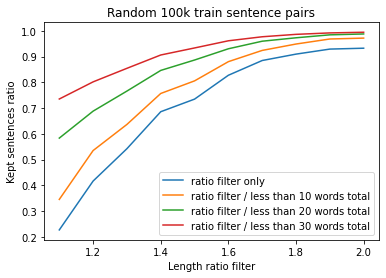

In [44]:
import matplotlib.pyplot as plt

plt.title("Random 100k train sentence pairs")
plt.xlabel("Length ratio filter")
plt.ylabel("Kept sentences ratio")

plt.plot(np.linspace(1.1, 2, 10),
         [((df['hun_word_count'] / df['eng_word_count'] < ratio) & (df['eng_word_count'] / df['hun_word_count'] < ratio)).mean()
          for ratio in np.linspace(1.1, 2, 10)
         ],
        label="ratio filter only")

for word_count in (10, 20, 30):

    plt.plot(np.linspace(1.1, 2, 10),
             [((df['hun_word_count'] + df['eng_word_count'] < word_count) |
                      (
                          (df['hun_word_count'] / df['eng_word_count'] < ratio) &
                          (df['eng_word_count'] / df['hun_word_count'] < ratio)
                      )
              ).mean()
              for ratio in np.linspace(1.1, 2, 10)
             ],
            label=f"ratio filter / less than {word_count} words total")

plt.legend(loc='lower right')
plt.show();

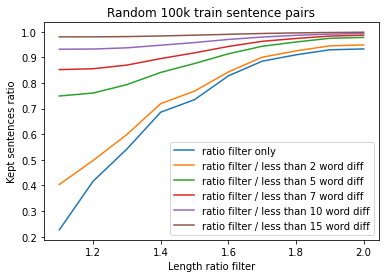

In [45]:
plt.title("Random 100k train sentence pairs")
plt.xlabel("Length ratio filter")
plt.ylabel("Kept sentences ratio")

plt.plot(np.linspace(1.1, 2, 10),
         [((df['hun_word_count'] / df['eng_word_count'] < ratio) & (df['eng_word_count'] / df['hun_word_count'] < ratio)).mean()
          for ratio in np.linspace(1.1, 2, 10)
         ],
        label="ratio filter only")

for word_count in (2, 5, 7, 10, 15):

    plt.plot(np.linspace(1.1, 2, 10),
             [(((df['hun_word_count'] - df['eng_word_count']).abs() < word_count) |
                      (
                          (df['hun_word_count'] / df['eng_word_count'] < ratio) &
                          (df['eng_word_count'] / df['hun_word_count'] < ratio)
                      )
              ).mean()
              for ratio in np.linspace(1.1, 2, 10)
             ],
            label=f"ratio filter / less than {word_count} word diff")

plt.legend(loc='lower right')
plt.show();

In [46]:
# sampler.save_splits_to_csv()

In [47]:
def filter_by_length(df):
    df.loc[:, 'hun_word_count'] = df['hun'].str.split().apply(len)
    df.loc[:, 'eng_word_count'] = df['eng'].str.split().apply(len)
    return df[(df['hun_word_count'] > 0) &
              (df['hun_word_count'] < 32) &
              (df['eng_word_count'] > 0) &
              (df['eng_word_count'] < 32) &
              (
                  ((df['hun_word_count'] - df['eng_word_count']).abs() < 7) |
                  (
                      (df['hun_word_count'] / df['eng_word_count'] < 1.2) &
                      (df['eng_word_count'] / df['hun_word_count'] < 1.2)
                  )
              )
             ]

In [48]:
sampler.train_set = filter_by_length(sampler.train_set)
sampler.valid_set = filter_by_length(sampler.valid_set)
sampler.test_set = filter_by_length(sampler.test_set)

In [49]:
sampler.train_set.shape, sampler.valid_set.shape, sampler.test_set.shape

((3333712, 6), (21673, 6), (21780, 6))

In [50]:
sampler.train_set.sort_values('hun_word_count')

,hun,eng,source_file,domain,hun_word_count,eng_word_count
3739340,SHORTWEEKDAY,SHORTWEEKDAY,opensource_7.bi,softwaredocs,1,1
3684622,Shisen-Sho,Shisen-Sho,opensource_8.bi,softwaredocs,1,1
3940753,Oh!,Oh!,subtitles.bi,subtitles,1,1
3940752,Vagyis?,-What?,subtitles.bi,subtitles,1,1
499027,Lemegy.,Go downstairs.,Shuffle,classic.lit,1,2
...,...,...,...,...,...,...
435542,"­ Fogd meg ­ mondta Fenchurch, és egy erős köt...","""Hold this,"" she said, shoved a stout rope in ...",Shuffle,classic.lit,31,31
1096232,Meg kell adni az egyes lemezekhez tartozó szám...,"Individual plate counts, the mean number of re...",32008R0440.bi,law,31,30
341287,"A hideg, kristályos csöndben a hatalmas fehér ...",In the cold crystal silence the huge white spi...,Shuffle,classic.lit,31,31
1351502,Megjegyzés: Az eredménykimutatás szerkezetére ...,Note: For the layout of the profit and loss ac...,32009R0250.bi,law,31,29


# Quotation marks

In [51]:
(sampler.train_set['hun'].str.startswith("\"")).mean()

0.0045168868816502445

In [52]:
(sampler.train_set['eng'].str.startswith("\"")).mean()

0.13250814707449235

In [53]:
sampler.train_set[sampler.train_set['eng'].str.startswith("\"")][:50]

,hun,eng,source_file,domain,hun_word_count,eng_word_count
0,- Igenis ön!,"""Yes; you!",Shuffle,classic.lit,3,2
1,"- Köszönöm, fiam - recsegte Mordon.","""Good boy,"" growled Moody.",Shuffle,classic.lit,6,4
11,- Mindnyájan jókedvűek vagytok.,"""You're all in good spirits.",Tolstoy_1.bi,classic.lit,4,5
12,- Cadiz felé!,"""Cadiz!",Twain_2.bi,classic.lit,3,1
13,"- Nemo kapitány, ön hívott bennünket.","""Captain Nemo, you have called us.",Verne_1.bi,classic.lit,6,6
14,"- Szavamra, nem ismerem elveinek minden apró r...","""Upon my word, I am not acquainted with the mi...",Austen_2.bi,classic.lit,8,13
16,- Adjatok időt.,"""Give me time.""",Shuffle,classic.lit,3,3
33,"- No persze, ennél mi sem egyszerűbb... - jegy...","""Nothing could be plainer than that,"" said Pen...",Verne_1.bi,classic.lit,11,8
37,"- Mondd el már, mit láttál.","""What have you seen? - come, tell me!""",Shuffle,classic.lit,6,8
44,"- Köszönöm, nagyon jól - felelte Anna.","""Thank you, very good,"" she answered.",Tolstoy_1.bi,classic.lit,7,6


## Remove quotation marks

In [54]:
test_df = sampler.train_set
test_df

,hun,eng,source_file,domain,hun_word_count,eng_word_count
0,- Igenis ön!,"""Yes; you!",Shuffle,classic.lit,3,2
1,"- Köszönöm, fiam - recsegte Mordon.","""Good boy,"" growled Moody.",Shuffle,classic.lit,6,4
2,Soha állatnak nem szabad megölnie egy másik ál...,No animal must ever kill any other animal.,Shuffle,classic.lit,8,8
3,"Miután leszüretelték, egy sötét és poros fiókr...",Once picked it needs a dark dusty drawer in wh...,Shuffle,classic.lit,13,16
5,"Az, hogy kidobja a régi hűtőjét, mindenképpen ...",Getting the old fridge thrown out was definite...,Shuffle,classic.lit,17,15
...,...,...,...,...,...,...
4103364,Találd meg Amanda-t!,Find Amanda!,subtitles.bi,subtitles,3,2
4103365,Ügyes.,That's good.,subtitles.bi,subtitles,1,2
4103366,Azt nézd meg.,CINDY: Look at this.,subtitles.bi,subtitles,3,4
4103367,"Visszatérne ujjaidba elfeledett erőd, ha régi ...",Your fingers would remember their old strength...,subtitles.bi,subtitles,9,8


In [55]:
test_df[110:120]

,hun,eng,source_file,domain,hun_word_count,eng_word_count
129,"Volt valami a leány arcában, ami arra késztett...",There was a something in her countenance which...,Austen_1.bi,classic.lit,16,20
130,Mindez a Harkonnenek műve lenne?,Was it the Harkonnens' doing?,Shuffle,classic.lit,5,5
131,"Nos, a hiányzó rabszolga megkerült.","Well, the missing slave was found.",Twain_2.bi,classic.lit,5,6
132,Ujjai néha dallamokat doboltak a karjain - men...,She sometimes played tunes upon them with her ...,Dickens_1.bi,classic.lit,19,21
133,- Egye meg a fene.,'What the hell.',Shuffle,classic.lit,5,3
134,"Paul becsatolta a cirkoruha csuklyáját, az arc...","Paul fastened his face filter, tightened the s...",Shuffle,classic.lit,11,9
136,"De szebb a Melegvíz: úri dolog,",but never did fountain sound so sweet,Shuffle,classic.lit,6,7
138,Narancsszínű fény világította meg a havat.,Orange flashes lit the snow.,Shuffle,classic.lit,6,5
139,"Menekülni akart, de amikor tekintete találkozo...","He would have fled, but his eyes met those of ...",France_1.bi,classic.lit,11,17
140,- Rendszerint a baj talál meg engem.,"""Trouble usually finds me.""",Shuffle,classic.lit,7,4


In [56]:
def remove_some_special_characters(text):
    replace_pairs = [('"', ''), ('-\ ', ''), ("'", '')]
    for pair in replace_pairs:
        text = re.sub(pair[0], pair[1], text)
    return text

In [57]:
test_df['hun'] = test_df['hun'].apply(remove_some_special_characters)
test_df['eng'] = test_df['eng'].apply(remove_some_special_characters)

<ipython-input-57-45ffdc2f42e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['hun'] = test_df['hun'].apply(remove_some_special_characters)
<ipython-input-57-45ffdc2f42e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['eng'] = test_df['eng'].apply(remove_some_special_characters)


In [28]:
test_df

,hun,eng,source_file,domain,hun_word_count,eng_word_count
0,Igenis ön!,Yes; you!,Shuffle,classic.lit,3,2
1,"Köszönöm, fiam recsegte Mordon.","Good boy, growled Moody.",Shuffle,classic.lit,6,4
2,Soha állatnak nem szabad megölnie egy másik ál...,No animal must ever kill any other animal.,Shuffle,classic.lit,8,8
3,"Miután leszüretelték, egy sötét és poros fiókr...",Once picked it needs a dark dusty drawer in wh...,Shuffle,classic.lit,13,16
5,"Az, hogy kidobja a régi hűtőjét, mindenképpen ...",Getting the old fridge thrown out was definite...,Shuffle,classic.lit,17,15
...,...,...,...,...,...,...
4103364,Találd meg Amanda-t!,Find Amanda!,subtitles.bi,subtitles,3,2
4103365,Ügyes.,Thats good.,subtitles.bi,subtitles,1,2
4103366,Azt nézd meg.,CINDY: Look at this.,subtitles.bi,subtitles,3,4
4103367,"Visszatérne ujjaidba elfeledett erőd, ha régi ...",Your fingers would remember their old strength...,subtitles.bi,subtitles,9,8


In [24]:
test_df[110:120]

,hun,eng,source_file,domain,hun_word_count,eng_word_count
129,"Volt valami a leány arcában, ami arra késztett...",There was a something in her countenance which...,Austen_1.bi,classic.lit,16,20
130,Mindez a Harkonnenek műve lenne?,Was it the Harkonnens doing?,Shuffle,classic.lit,5,5
131,"Nos, a hiányzó rabszolga megkerült.","Well, the missing slave was found.",Twain_2.bi,classic.lit,5,6
132,Ujjai néha dallamokat doboltak a karjain menüe...,She sometimes played tunes upon them with her ...,Dickens_1.bi,classic.lit,19,21
133,Egye meg a fene.,What the hell.,Shuffle,classic.lit,5,3
134,"Paul becsatolta a cirkoruha csuklyáját, az arc...","Paul fastened his face filter, tightened the s...",Shuffle,classic.lit,11,9
136,"De szebb a Melegvíz: úri dolog,",but never did fountain sound so sweet,Shuffle,classic.lit,6,7
138,Narancsszínű fény világította meg a havat.,Orange flashes lit the snow.,Shuffle,classic.lit,6,5
139,"Menekülni akart, de amikor tekintete találkozo...","He would have fled, but his eyes met those of ...",France_1.bi,classic.lit,11,17
140,Rendszerint a baj talál meg engem.,Trouble usually finds me.,Shuffle,classic.lit,7,4


In [58]:
test_df.loc[:, 'hun_word_count'] = test_df['hun'].str.split().apply(len)
test_df.loc[:, 'eng_word_count'] = test_df['eng'].str.split().apply(len)

/home1/hu-nmt/miniconda3/envs/nmt38/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [66]:
test_df.sort_values('hun_word_count')[:10]

,hun,eng,source_file,domain,hun_word_count,eng_word_count
3691812,,,opensource_2.bi,softwaredocs,0,0
2443822,,,hunglish1.lit.bi,modern.lit,0,0
2500531,,,hunglish1.lit.bi,modern.lit,0,0
3716818,,,opensource_2.bi,softwaredocs,0,0
3672784,,,opensource_2.bi,softwaredocs,0,0
530616,,,Shuffle,classic.lit,0,0
3716820,,,opensource_2.bi,softwaredocs,0,0
3689687,,,opensource_2.bi,softwaredocs,0,0
3705224,,,opensource_2.bi,softwaredocs,0,0
830803,,,constitution.bi,law,0,0


In [65]:
sampler.train_set['hun'][3691812]

''

In [25]:
sampler.train_set['hun'] = sampler.train_set['hun'].apply(remove_some_special_characters)
sampler.train_set['eng'] = sampler.train_set['eng'].apply(remove_some_special_characters)
sampler.valid_set['hun'] = sampler.valid_set['hun'].apply(remove_some_special_characters)
sampler.valid_set['eng'] = sampler.valid_set['eng'].apply(remove_some_special_characters)
sampler.test_set['hun'] = sampler.test_set['hun'].apply(remove_some_special_characters)
sampler.test_set['eng'] = sampler.test_set['eng'].apply(remove_some_special_characters)

<ipython-input-25-14bf40d13d7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampler.train_set['hun'] = sampler.train_set['hun'].apply(remove_some_special_characters)
<ipython-input-25-14bf40d13d7d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampler.train_set['eng'] = sampler.train_set['eng'].apply(remove_some_special_characters)
<ipython-input-25-14bf40d13d7d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [31]:
sampler.train_set.shape, sampler.valid_set.shape, sampler.test_set.shape

((3333712, 6), (21673, 6), (21780, 6))

In [32]:
sampler.train_set = filter_by_length(sampler.train_set)
sampler.valid_set = filter_by_length(sampler.valid_set)
sampler.test_set = filter_by_length(sampler.test_set)

/home1/hu-nmt/miniconda3/envs/nmt38/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home1/hu-nmt/miniconda3/envs/nmt38/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home1/hu-nmt/miniconda3/envs/nmt38/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is tryi

In [33]:
sampler.train_set.shape, sampler.valid_set.shape, sampler.test_set.shape

((3322594, 6), (21636, 6), (21730, 6))

## Export data

In [34]:
def create_data_set_files(sampler, path, base_file_name):
    file_name_beginning = join(path, base_file_name + '-')
    
    f = lambda set_name, language: file_name_beginning + set_name + '.' + language
    
    sampler.train_set['hun'][:].to_csv(f('train', 'hu'), header=None, index=None, sep='\t')
    sampler.train_set['eng'][:].to_csv(f('train', 'en'), header=None, index=None, sep='\t')
    
    sampler.valid_set['hun'][:].to_csv(f('valid', 'hu'), header=None, index=None, sep='\t')
    sampler.valid_set['eng'][:].to_csv(f('valid', 'en'), header=None, index=None, sep='\t')
    
    sampler.test_set['hun'][:].to_csv(f('test', 'hu'), header=None, index=None, sep='\t')
    sampler.test_set['eng'][:].to_csv(f('test', 'en'), header=None, index=None, sep='\t')

In [35]:
combined_path = join(hunglish_path, 'combined-32-simple')
if not exists(combined_path):
    mkdir(combined_path)
create_data_set_files(sampler, hunglish_path, 'combined-32-simple/hunglish2')